# SQS elastic constants

This notebook demonstrates the functionality of job classes designed to calculate chemistry-dependent elastic data by averaging over one or more special-quasirandom structures.

In [1]:
from pyiron import Project
import pyiron_contrib
from elastic import ElasticMatrixJob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
pr = Project('scratch1')
#pr.remove_jobs(recursive=True)

# Setup reference jobs

The input to these SQS elastic job classes is quite minimal, rather run parameters are passed in in the form of reference jobs.

Of special importance are the `SQSJob` type reference, which handles the generation of special quasirandom structures, and `ElasticMatrixJob`, which computes the elastic constants. Thankfully, these jobs already existed, so the development of the new SQS elastic jobs was just a matter of stringing them together. 

An advantage of this setup is that any new improvements to the functionality of these underlying jobs is included in the SQS elastic jobs without having to modify SQS elastic code specifically, since they appear simply as references. However, the flip side of the coin is that the functionality of these jobs was not exhaustively tested. Results are very reasonable for the FCC Al system tested, but keep your physicist hat on when running the code and ensure that your results are coming out sensibly.

The final and most basic reference is the model which will interpret atomic positions to produce forces and energies. Here we'll use Lammps, but, if you have a lot of processor power lying around, there should be no barrier to using a quantum mechanical code like Vasp instead.

Here, we'll scale a lot of the input parameters way back so the calculations run faster.

In [3]:
lammps = pr.create_job(pr.job_type.Lammps, 'hr')
lammps.structure = pr.create_ase_bulk('Cu', cubic=True).repeat(5)
lammps.structure[:3] = 'Ni'

In [4]:
lammps.list_potentials()

['FeCuNi_eam_alloy',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr2',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr1',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr2',
 '1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 '1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 'EAM_Dynamo_BonnyPasianotCastin_2009_FeCuNi__MO_469343973171_005',
 'EAM_Dynamo_OnatDurukanoglu_2014_CuNi__MO_592013496703_005',
 'EMT_Asap_Standard_JacobsenStoltzeNorskov_1996_AlAgAuCuNiPdPt__MO_115316750986_001']

In [5]:
lammps.potential = lammps.list_potentials()[1]
lammps.potential

,Config,Filename,Model,Name,Species
170,"[pair_style eam\n, pair_coeff 1 1 Cu_smf7.eam\...",[NISTiprpy/1985--Foiles-S-M--Ni-Cu--LAMMPS--ip...,NISTiprpy,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[Cu, Ni]"
385,"[pair_style eam\n, pair_coeff 1 1 Cu_smf7.eam\...",[NISTiprpy/1985--Foiles-S-M--Ni-Cu--LAMMPS--ip...,NISTiprpy,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[Cu, Ni]"


In [6]:
sqs = pr.create_job(pr.job_type.SQSJob, 'sr')
sqs.input.iterations = 100
sqs.input.weights = None
sqs.input.n_output_structures = 2 

In [7]:
elastic = pr.create_job(ElasticMatrixJob, 'er')
elastic.input['num_of_points'] = 3
elastic.input['fit_order'] = 2
elastic.input['eps_range'] = 0.005
elastic.input['relax_atoms'] = False
elastic.input['sqrt_eta'] = False

# Option 1: A single composition

If we're interested in a single chemical composition, we can run the calculation for that directly and look at the statistical properties of the output.

In [8]:
sqs_elastic = pr.create_job(pr.job_type.SQSElasticConstants, 'single')
sqs_elastic.ref_ham = lammps
sqs_elastic.ref_sqs = sqs
sqs_elastic.ref_elastic = elastic
sqs_elastic.run()

The job single_ham_ref was saved and received the ID: 1123
The job single_sqs_ref was saved and received the ID: 1124
The job single_el_job was saved and received the ID: 1125
The job single was saved and received the ID: 1126
The job single_sqs was saved and received the ID: 1127
Threads used: 1
The job single_min was saved and received the ID: 1128
The job struct_0 was saved and received the ID: 1129
The job struct_1 was saved and received the ID: 1130
The job single_elastic was saved and received the ID: 1131
The job struct_0 was saved and received the ID: 1132
The job s_e_0 was saved and received the ID: 1133
The job s_02_e_m0_00500 was saved and received the ID: 1134
The job s_02_e_0_00500 was saved and received the ID: 1135
The job s_03_e_m0_00500 was saved and received the ID: 1136
The job s_03_e_0_00500 was saved and received the ID: 1137
The job s_04_e_m0_00500 was saved and received the ID: 1138
The job s_04_e_0_00500 was saved and received the ID: 1139
The job s_05_e_m0_0050

In [9]:
sqs_elastic.output.elastic_matrices.sem

array([[2.83485581e-06, 1.74575798e-05, 4.95426402e-06, 2.96520779e-06,
        1.97128201e-05, 5.33976553e-06],
       [1.74575798e-05, 1.00048169e-05, 1.99366993e-05, 1.63456415e-05,
        5.13441413e-06, 2.58586738e-05],
       [4.95426402e-06, 1.99366993e-05, 7.00689204e-06, 1.78824825e-05,
        1.94388153e-05, 1.79858455e-06],
       [2.96520779e-06, 1.63456415e-05, 1.78824825e-05, 1.30177449e-05,
        3.49222192e-06, 8.23655671e-06],
       [1.97128201e-05, 5.13441413e-06, 1.94388153e-05, 3.49222192e-06,
        4.23907423e-06, 5.53970240e-06],
       [5.33976553e-06, 2.58586738e-05, 1.79858455e-06, 8.23655671e-06,
        5.53970240e-06, 1.54834690e-05]])

In [10]:
sqs_elastic_loaded = pr.load(sqs_elastic.job_name)

In [11]:
sqs_elastic_loaded.output.elastic_matrices.mean

array([[ 1.68872245e+02,  1.23600113e+02,  1.23600017e+02,
        -5.90774935e-03,  3.01185086e-02,  3.02009732e-02],
       [ 1.23600113e+02,  1.68872250e+02,  1.23600011e+02,
         3.01478771e-02, -5.89989162e-03,  3.02129285e-02],
       [ 1.23600017e+02,  1.23600011e+02,  1.68872234e+02,
         3.01560293e-02,  3.01294629e-02, -5.90493081e-03],
       [-5.90774935e-03,  3.01478771e-02,  3.01560293e-02,
         7.68189266e+01, -7.99667005e-03, -7.98163853e-03],
       [ 3.01185086e-02, -5.89989162e-03,  3.01294629e-02,
        -7.99667005e-03,  7.68189381e+01, -7.98076636e-03],
       [ 3.02009732e-02,  3.02129285e-02, -5.90493081e-03,
        -7.98163853e-03, -7.98076636e-03,  7.68190030e+01]])

In [12]:
sqs_elastic_loaded.output.residual_pressures

/opt/conda/lib/python3.8/site-packages/pyiron_base/generic/inputlist.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(self._store)


[array([[ 1.97927135e-06,  3.45262851e-06,  1.71016987e-06],
       [ 3.45262851e-06, -4.64238843e-06, -4.31727860e-06],
       [ 1.71016987e-06, -4.31727860e-06,  3.62191808e-06]])
 array([[ 7.23968335e-07,  9.91608517e-06, -8.95669129e-06],
       [ 9.91608517e-06,  2.57074667e-06,  9.69378574e-06],
       [-8.95669129e-06,  9.69378574e-06, -2.39090507e-06]])
 None None None]

# Option 2: Scan various compositions

Alternatively, we might want to look for chemical trends across multiple different compositions. This is also possible. 

In [13]:
sqs_elastic_ref = pr.create_job(pr.job_type.SQSElasticConstants, 'se')
sqs_elastic_ref.ref_ham = lammps
sqs_elastic_ref.ref_sqs = sqs
sqs_elastic_ref.ref_elastic = elastic

job = sqs_elastic_ref.create_job(pr.job_type.SQSElasticConstantsList, 'scan')
job.input.compositions = [
    {'Cu': 1., 'Ni': 0.},
    {'Cu': 0.95, 'Ni': 0.05},
    {'Cu': 0.90, 'Ni': 0.10},
    {'Cu': 0.85, 'Ni': 0.15},
    {'Cu': 0.80, 'Ni': 0.20},
    {'Cu': 0.70, 'Ni': 0.30},
    {'Cu': 0.60, 'Ni': 0.40},
    {'Cu': 0.50, 'Ni': 0.50},
    {'Cu': 0.40, 'Ni': 0.60},
    {'Cu': 0.30, 'Ni': 0.70},
    {'Cu': 0.20, 'Ni': 0.80},
    {'Cu': 0.10, 'Ni': 0.90},
    {'Cu': 0., 'Ni': 1.}
]
job.run()

The job se_ham_ref was saved and received the ID: 1220
The job se_sqs_ref was saved and received the ID: 1221
The job se_el_job was saved and received the ID: 1222
The job scan was saved and received the ID: 1223
The job Cu10_Ni00_ham_ref was saved and received the ID: 1224
The job Cu10_Ni00_sqs_ref was saved and received the ID: 1225
The job Cu10_Ni00_el_job was saved and received the ID: 1226
The job Cu10_Ni00 was saved and received the ID: 1227
The job Cu10_Ni00_sqs was saved and received the ID: 1228
Threads used: 1
The job Cu10_Ni00_min was saved and received the ID: 1229
The job struct_0 was saved and received the ID: 1230
The job Cu10_Ni00_elastic was saved and received the ID: 1231
The job struct_0 was saved and received the ID: 1232
The job s_e_0 was saved and received the ID: 1233
The job s_01_e_m0_00500 was saved and received the ID: 1234
The job s_01_e_0_00500 was saved and received the ID: 1235
The job s_08_e_m0_00500 was saved and received the ID: 1236
The job s_08_e_0_00

Threads used: 1
The job Cu085_Ni015_min was saved and received the ID: 1358
The job struct_0 was saved and received the ID: 1359
The job Cu085_Ni015_elastic was saved and received the ID: 1360
The job struct_0 was saved and received the ID: 1361
The job s_e_0 was saved and received the ID: 1362
The job s_02_e_m0_00500 was saved and received the ID: 1363
The job s_02_e_0_00500 was saved and received the ID: 1364
The job s_03_e_m0_00500 was saved and received the ID: 1365
The job s_03_e_0_00500 was saved and received the ID: 1366
The job s_04_e_m0_00500 was saved and received the ID: 1367
The job s_04_e_0_00500 was saved and received the ID: 1368
The job s_05_e_m0_00500 was saved and received the ID: 1369
The job s_05_e_0_00500 was saved and received the ID: 1370
The job s_06_e_m0_00500 was saved and received the ID: 1371
The job s_06_e_0_00500 was saved and received the ID: 1372
The job s_07_e_m0_00500 was saved and received the ID: 1373
The job s_07_e_0_00500 was saved and received the

The job s_13_e_0_00500 was saved and received the ID: 1496
The job s_14_e_m0_00500 was saved and received the ID: 1497
The job s_14_e_0_00500 was saved and received the ID: 1498
The job s_15_e_m0_00500 was saved and received the ID: 1499
The job s_15_e_0_00500 was saved and received the ID: 1500
The job s_16_e_m0_00500 was saved and received the ID: 1501
The job s_16_e_0_00500 was saved and received the ID: 1502
The job s_17_e_m0_00500 was saved and received the ID: 1503
The job s_17_e_0_00500 was saved and received the ID: 1504
The job s_18_e_m0_00500 was saved and received the ID: 1505
The job s_18_e_0_00500 was saved and received the ID: 1506
The job s_19_e_m0_00500 was saved and received the ID: 1507
The job s_19_e_0_00500 was saved and received the ID: 1508
The job s_20_e_m0_00500 was saved and received the ID: 1509
The job s_20_e_0_00500 was saved and received the ID: 1510
The job s_21_e_m0_00500 was saved and received the ID: 1511
The job s_21_e_0_00500 was saved and received th

The job struct_0 was saved and received the ID: 1634
The job Cu04_Ni06_elastic was saved and received the ID: 1635
The job struct_0 was saved and received the ID: 1636
The job s_e_0 was saved and received the ID: 1637
The job s_02_e_m0_00500 was saved and received the ID: 1638
The job s_02_e_0_00500 was saved and received the ID: 1639
The job s_03_e_m0_00500 was saved and received the ID: 1640
The job s_03_e_0_00500 was saved and received the ID: 1641
The job s_04_e_m0_00500 was saved and received the ID: 1642
The job s_04_e_0_00500 was saved and received the ID: 1643
The job s_05_e_m0_00500 was saved and received the ID: 1644
The job s_05_e_0_00500 was saved and received the ID: 1645
The job s_06_e_m0_00500 was saved and received the ID: 1646
The job s_06_e_0_00500 was saved and received the ID: 1647
The job s_07_e_m0_00500 was saved and received the ID: 1648
The job s_07_e_0_00500 was saved and received the ID: 1649
The job s_08_e_m0_00500 was saved and received the ID: 1650
The job 

The job s_14_e_0_00500 was saved and received the ID: 1773
The job s_15_e_m0_00500 was saved and received the ID: 1774
The job s_15_e_0_00500 was saved and received the ID: 1775
The job s_16_e_m0_00500 was saved and received the ID: 1776
The job s_16_e_0_00500 was saved and received the ID: 1777
The job s_17_e_m0_00500 was saved and received the ID: 1778
The job s_17_e_0_00500 was saved and received the ID: 1779
The job s_18_e_m0_00500 was saved and received the ID: 1780
The job s_18_e_0_00500 was saved and received the ID: 1781
The job s_19_e_m0_00500 was saved and received the ID: 1782
The job s_19_e_0_00500 was saved and received the ID: 1783
The job s_20_e_m0_00500 was saved and received the ID: 1784
The job s_20_e_0_00500 was saved and received the ID: 1785
The job s_21_e_m0_00500 was saved and received the ID: 1786
The job s_21_e_0_00500 was saved and received the ID: 1787
The job s_22_e_m0_00500 was saved and received the ID: 1788
The job s_22_e_0_00500 was saved and received th

2020-11-06 09:32:11,714 - pyiron_log - WARNING - Job 'Cu10_Ni00_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:11,719 - pyiron_log - WARNING - Job 'Cu10_Ni00_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:11,725 - pyiron_log - WARNING - Job 'Cu10_Ni00_el_job' does not exist and cannot be loaded
2020-11-06 09:32:11,875 - pyiron_log - WARNING - Job 'Cu095_Ni005_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:11,881 - pyiron_log - WARNING - Job 'Cu095_Ni005_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:11,886 - pyiron_log - WARNING - Job 'Cu095_Ni005_el_job' does not exist and cannot be loaded
2020-11-06 09:32:12,037 - pyiron_log - WARNING - Job 'Cu09_Ni01_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:12,042 - pyiron_log - WARNING - Job 'Cu09_Ni01_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:12,048 - pyiron_log - WARNING - Job 'Cu09_Ni01_el_job' does not exist and cannot be loaded
2020-11-06 09:32

2020-11-06 09:32:15,999 - pyiron_log - WARNING - Job 'Cu00_Ni10_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:16,004 - pyiron_log - WARNING - Job 'Cu00_Ni10_el_job' does not exist and cannot be loaded
2020-11-06 09:32:16,389 - pyiron_log - WARNING - Job 'Cu10_Ni00_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:16,394 - pyiron_log - WARNING - Job 'Cu10_Ni00_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:16,399 - pyiron_log - WARNING - Job 'Cu10_Ni00_el_job' does not exist and cannot be loaded
2020-11-06 09:32:16,552 - pyiron_log - WARNING - Job 'Cu095_Ni005_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:16,558 - pyiron_log - WARNING - Job 'Cu095_Ni005_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:16,563 - pyiron_log - WARNING - Job 'Cu095_Ni005_el_job' does not exist and cannot be loaded
2020-11-06 09:32:16,713 - pyiron_log - WARNING - Job 'Cu09_Ni01_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32

2020-11-06 09:32:20,508 - pyiron_log - WARNING - Job 'Cu01_Ni09_el_job' does not exist and cannot be loaded
2020-11-06 09:32:20,658 - pyiron_log - WARNING - Job 'Cu00_Ni10_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:20,663 - pyiron_log - WARNING - Job 'Cu00_Ni10_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:20,669 - pyiron_log - WARNING - Job 'Cu00_Ni10_el_job' does not exist and cannot be loaded
2020-11-06 09:32:21,054 - pyiron_log - WARNING - Job 'Cu10_Ni00_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:21,059 - pyiron_log - WARNING - Job 'Cu10_Ni00_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:21,065 - pyiron_log - WARNING - Job 'Cu10_Ni00_el_job' does not exist and cannot be loaded
2020-11-06 09:32:21,215 - pyiron_log - WARNING - Job 'Cu095_Ni005_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:21,220 - pyiron_log - WARNING - Job 'Cu095_Ni005_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:2

2020-11-06 09:32:25,148 - pyiron_log - WARNING - Job 'Cu01_Ni09_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:25,154 - pyiron_log - WARNING - Job 'Cu01_Ni09_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:25,159 - pyiron_log - WARNING - Job 'Cu01_Ni09_el_job' does not exist and cannot be loaded
2020-11-06 09:32:25,310 - pyiron_log - WARNING - Job 'Cu00_Ni10_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:25,316 - pyiron_log - WARNING - Job 'Cu00_Ni10_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:25,321 - pyiron_log - WARNING - Job 'Cu00_Ni10_el_job' does not exist and cannot be loaded
2020-11-06 09:32:25,707 - pyiron_log - WARNING - Job 'Cu10_Ni00_ham_ref' does not exist and cannot be loaded
2020-11-06 09:32:25,713 - pyiron_log - WARNING - Job 'Cu10_Ni00_sqs_ref' does not exist and cannot be loaded
2020-11-06 09:32:25,718 - pyiron_log - WARNING - Job 'Cu10_Ni00_el_job' does not exist and cannot be loaded
2020-11-06 09:32:25,86

In [14]:
loaded = pr.load(job.job_name)

<AxesSubplot:xlabel='Ni Atomic fraction', ylabel='Elastic constants (GPa)'>

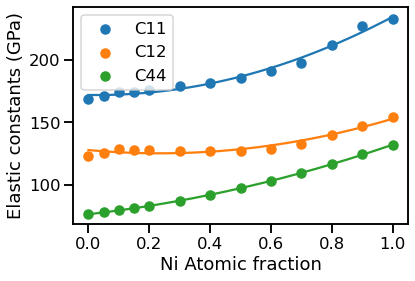

In [15]:
loaded.plot('Ni')

## DAMASK simulations
Here, we use the above fits to the data from lammps MD simulation to find the elastic constansts for a selected set of Ni concentrations. Then these values are given to DAMASK simulations to obtain the macroscopic elasto-plastic response.    

In [16]:
import os
cwd = os.getcwd()
print(cwd)
os.chdir(cwd)

/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow


In [17]:
concentrations=[0.2,0.6,1.0]

In [18]:
from damask import Geom
from damask import seeds
#import numpy as np
import subprocess,shlex
import os
import damask
from simulation_runner import simulation
simulation_folder =[]
job_file = []
grid = np.array([16,16,16])
size = np.array([1.0,1.0,1.0])
grains = 20
seeds = seeds.from_random(size,grains)
for i,c in enumerate(concentrations):
    os.chdir(cwd)
    simulation_folder.append('Ni-{}'.format(int(c*100)))
    os.system('mkdir {}'.format(simulation_folder[i]))
    os.system('cp Examples/material.yaml {}'.format(simulation_folder[i]))
    os.system('cp Examples/tensionX.load {}/tension_Ni{}.load'.format(simulation_folder[i],int(c*100)))
    path = cwd+'/'+simulation_folder[i];
    print(path)
    C11 = float(loaded.get_C11_poly('Ni')(c))
    C12 = float(loaded.get_C12_poly('Ni')(c))
    C44 = float(loaded.get_C44_poly('Ni')(c))
    print("moduli: {}, {}, {}".format(C11,C12,C44))
    print(simulation_folder[i])
    #os.chdir(simulation_folder[i])
    os.chdir(path)
#    os.system('rm *.hdf5')
    load = 'tension_Ni{}.load'.format(int(c*100))
    geom_name = 'test.geom'
    material_config = 'material.yaml'
    job_file.append('{}_{}.hdf5'.format(geom_name.split('.')[0],load.split('.')[0]))
    new_geom = Geom.from_Voronoi_tessellation(grid,size,seeds)
    new_geom.save_ASCII(geom_name)
    new_geom.save(geom_name.split('.')[0])
    C_matrix = [C11*1e9,C12*1e9,C44*1e9]
    elasticity={}
    elasticity.update({'type': 'hooke'})
    elastic_constants = {'C_11': C_matrix[0], 'C_12': C_matrix[1], 'C_44': C_matrix[2]}
    elasticity.update(elastic_constants)
    mat = damask.Config.load(material_config)
    mat['phase']['Aluminum']['elasticity'] = elasticity
    mat.save(material_config)
    simulation.run(simulation_folder[i],geom_name,load)
    print('simulation {} done'.format(str(i)))

/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-20
moduli: 173.9030299247348, 125.44876129467421, 83.40675542859164
Ni-20
simulation 0 done
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-60
moduli: 193.60050115597033, 131.69257084929467, 103.40471090689269
Ni-60
simulation 1 done
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-100
moduli: 234.45421462609815, 153.01950822106875, 132.30423976678765
Ni-100
simulation 2 done


## post processing of DAMASK simulations
Here, the data from damask simulations are post-process to obtain the list of strain, stress, and Von-Mises stress.

In [19]:
os.chdir(cwd)
import damask
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as PyPlot
import numpy as np
import h5py
#from Plot_stress_strain import plot
from damask_eval import eval_stress , eval_strain
%matplotlib inline
d = []
stresses = []
strains = []
#os.chdir(cwd)
for i,c in enumerate(concentrations):
    path = cwd+'/'+simulation_folder[i];
    os.chdir(path)
    #os.chdir(simulation_folder[i])
    d.append(damask.Result(job_file[i]))                  
    d[i].add_Cauchy()
    d[i].add_strain_tensor()
    d[i].add_Mises('sigma')
    d[i].add_Mises('epsilon_V^0.0(F)')
    d[i].add_calculation('avg_sigma',"np.average(#sigma_vM#)")
    d[i].add_calculation('avg_epsilon',"np.average(#epsilon_V^0.0(F)_vM#)")
    d[i].save_vtk(['sigma','epsilon_V^0.0(F)','sigma_vM','epsilon_V^0.0(F)_vM'])
    stresses.append(eval_stress(job_file[i]))
    strains.append(eval_strain(job_file[i]))

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/damask_eval.py:19: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)
/home/pyiron_user/pyiron/projects/pyir

## Visualization
Here, you can find the stress-strain relation for different concentrations of Ni in a Cu-Ni alloy. The main difference lies in the elastic part. Therefore, the stain range is modified to visualize elastic deformation better.

Text(0.5, 1.0, 'Stress-Strain')

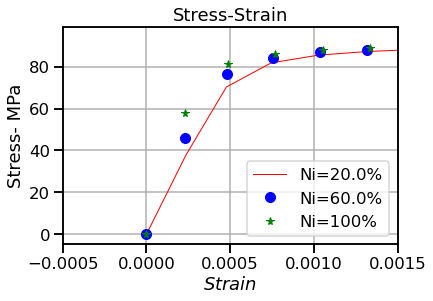

In [20]:
import matplotlib.pyplot as plt
i = 0;
#stresses[0]= eval_stress(job_file[0])
#stresses[1]= eval_stress(job_file[1])
#stresses[2]= eval_stress(job_file[2])
colors = ['r','g','b']
#for color, strain, stress, c in zip(colors, strains, stresses, concentrations):
plt.plot(strains[0], stresses[0], 'r', linewidth=1, label = 'Ni={}%'.format(0.2*100))
plt.plot(strains[1], stresses[1], 'b', linestyle="None",marker = 'o' ,markersize = 10,label = 'Ni={}%'.format(0.6*100))
plt.plot(strains[2], stresses[2], 'g', linestyle="None",marker = '*', markersize = 8 ,label = 'Ni={}%'.format(1*100))
plt.xlim(-0.0005,0.0015)
plt.grid(True)
plt.xlabel('$Strain$')
plt.ylabel('Stress- MPa')
plt.legend( loc='lower right')
plt.title("Stress-Strain")

## VTK visualization

Import visualization modules

In [21]:
import pyvista as pv
from itkwidgets import view

Visualizing initial geometry

In [29]:
path = cwd+'/'+simulation_folder[i]
filepath = path + '/' + 'test.vtr' # put correct name for the geometry file
mesh = pv.read(filepath)
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Visualize stress-strain distributions etc. 

In [26]:
path = cwd+'/'+simulation_folder[i]
filepath = path + '/' + 'test_tension_Ni20_inc20.vtr'   #put the correct name for the vtr file
mesh = pv.read(filepath)
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [27]:
mesh

RectilinearGrid (0x7f7f909f4a60)
  N Cells:	4096
  N Points:	4913
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	17, 17, 17
  N Arrays:	5

In [28]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [30]:
mesh

RectilinearGrid (0x7f7f90a06a00)
  N Cells:	4096
  N Points:	4913
  X Bounds:	0.000e+00, 1.000e+00
  Y Bounds:	0.000e+00, 1.000e+00
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	17, 17, 17
  N Arrays:	2

In [31]:
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…